# VISUALIZE experiments results

In this visualization notebook, we will see how all the models behave, and how the different parameters affect model performance for the different available models, which are:

* Linear models
* KNN regression models
* XGBoost models

All models have similar and different behaviours. As an example, maybe all behave bad in certain locations, but some models might behave better with local predictors, while others might obtain better results when adding a regional + gradient predictor.

In [14]:
# datasets
import xarray as xr

# append sscode to path
import sys, os
sys.path.insert(0, '/Users/administrador/Documents/geocean-nz-ss')
data_path = '/Volumes/ToshibaJT/geocean-nz-ss/data'
os.environ["SSURGE_DATA_PATH"] = data_path

from sscode.plotting.results import ResultsPlotter
%matplotlib inline

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# load the 3 models datasets
linear_stats = xr.open_dataset('../data/statistics/experiments/experiment_linear_final_20220202.nc')\
    .sortby(['grad','winds'],ascending=True)
knn_stats = xr.open_dataset('../data/statistics/experiments/experiment_knn_final_20220202.nc')\
    .sortby(['grad','winds'],ascending=True)
xgb_stats = xr.open_dataset('../data/statistics/experiments/experiment_xgboost_final_20220128.nc')\
    .sortby(['grad','winds'],ascending=True)

In [3]:
linear_stats

<xarray.Dataset>
Dimensions:                (site: 29, grad: 2, winds: 2, tlapse: 3, tresample: 3, region: 3, tsize: 1, perpcs: 6)
Coordinates:
  * site                   (site) int64 116 200 224 328 ... 1260 1296 1327 1442
  * grad                   (grad) int8 0 1
  * winds                  (winds) int8 0 1
  * tlapse                 (tlapse) int64 1 2 3
  * tresample              (tresample) object '6H' '12H' '1D'
  * region                 (region) object 'local_1.5_1.5' ... 'default_regio...
  * tsize                  (tsize) float64 0.7
  * perpcs                 (perpcs) float64 0.9 0.95 0.96 0.97 0.98 0.99
Data variables: (12/61)
    bias                   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    si                     (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse                   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rel_rmse               (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse_9                 (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse_95                (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ...                     ...
    ext_kgeprime_gamma_95  (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_beta_95   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_99        (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_r_99      (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_gamma_99  (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_beta_99   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...

In [4]:
print(
    'The 3 statistical models have dimensions: \n',
    f'LINEAR model:  {list(linear_stats.dims)} \n',
    f'KNN model:     {list(knn_stats.dims)} \n',
    f'XGBOOST model: {list(xgb_stats.dims)} \n'
)
print(
    'CHECK DIMENSIONS ARE CORRECTLY SORTED WITH SAME VALUES AND CROP TO COMMON ONES!!'
)

The 3 statistical models have dimensions: 
 LINEAR model:  ['site', 'grad', 'winds', 'tlapse', 'tresample', 'region', 'tsize', 'perpcs'] 
 KNN model:     ['site', 'grad', 'winds', 'tlapse', 'tresample', 'region', 'tsize', 'perpcs', 'k_neighbors'] 
 XGBOOST model: ['site', 'grad', 'winds', 'tlapse', 'tresample', 'region', 'tsize', 'perpcs', 'n_estimators', 'max_depth', 'min_samples_split', 'learning_rate', 'loss'] 

CHECK DIMENSIONS ARE CORRECTLY SORTED WITH SAME VALUES AND CROP TO COMMON ONES!!


In [5]:
# crop datasets to same dimensions to compare
linear_stats_red = linear_stats.max(
    dim=['perpcs'])
knn_stats_red = knn_stats.max(
    dim=['perpcs','k_neighbors'])
xgb_stats_red = xgb_stats.max(
    dim=['perpcs','n_estimators','max_depth','min_samples_split','learning_rate','loss'])

## Initialize the `class` to plot results

In [6]:
results = ResultsPlotter(
    linear_stats=linear_stats,
    knn_stats=knn_stats,
    xgb_stats=xgb_stats,
    linear_stats_red=linear_stats_red,
    knn_stats_red=knn_stats_red,
    xgb_stats_red=xgb_stats_red
)

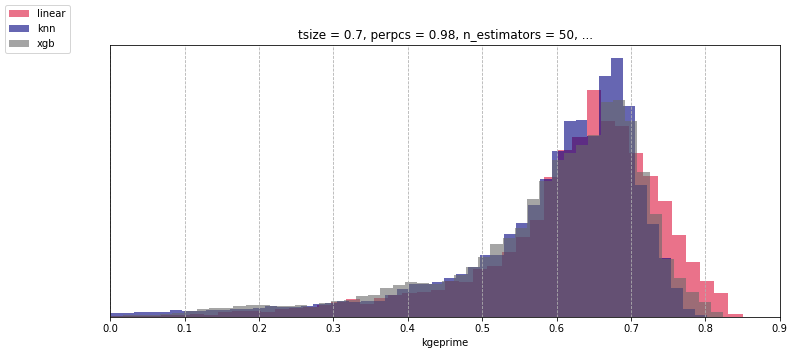

In [7]:
results.plot_histogram()

In [8]:
# %matplotlib
# results.plot_studied_locations()

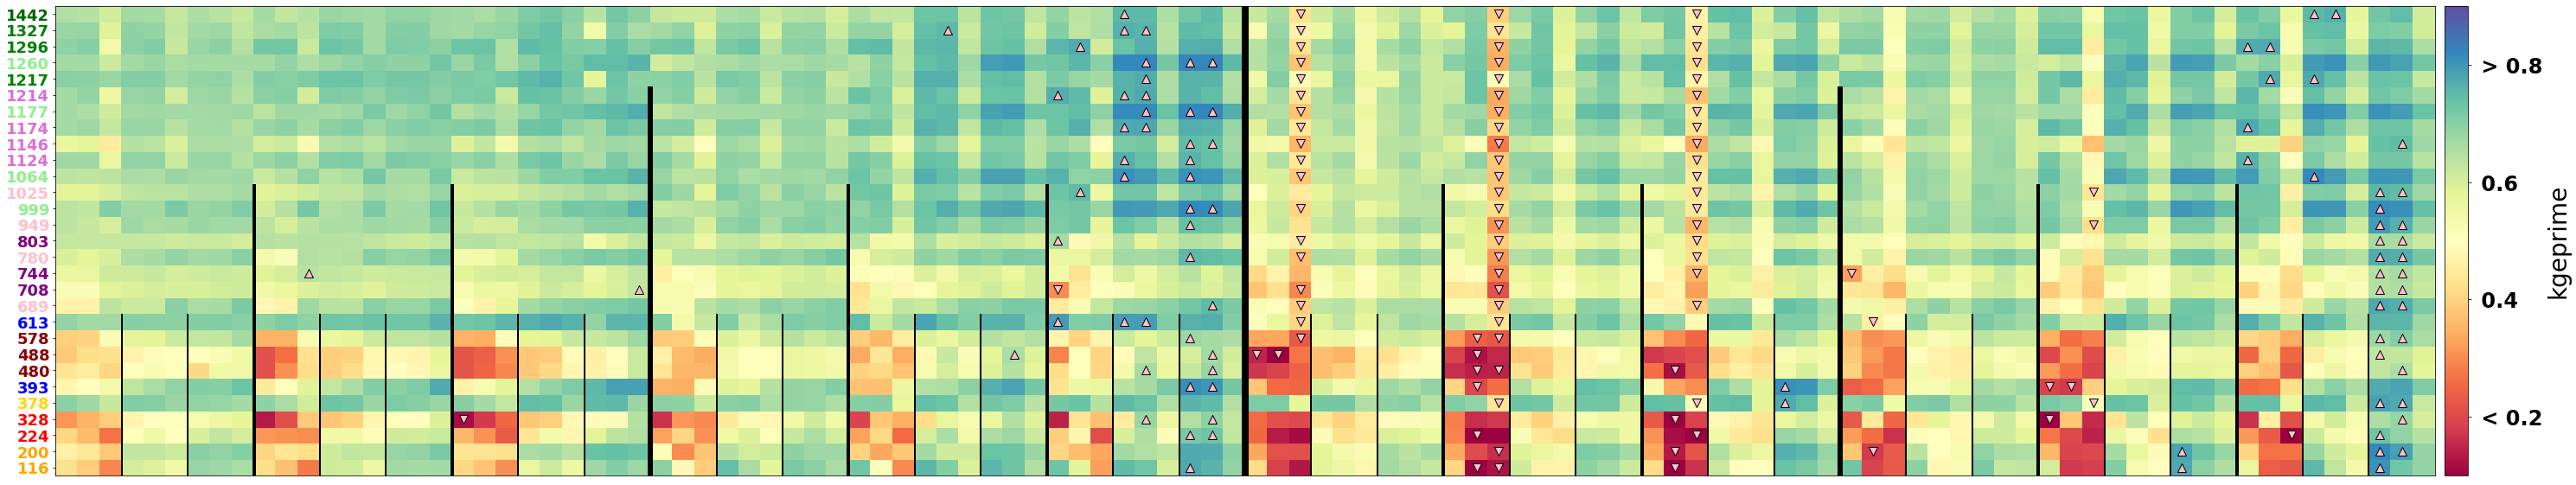

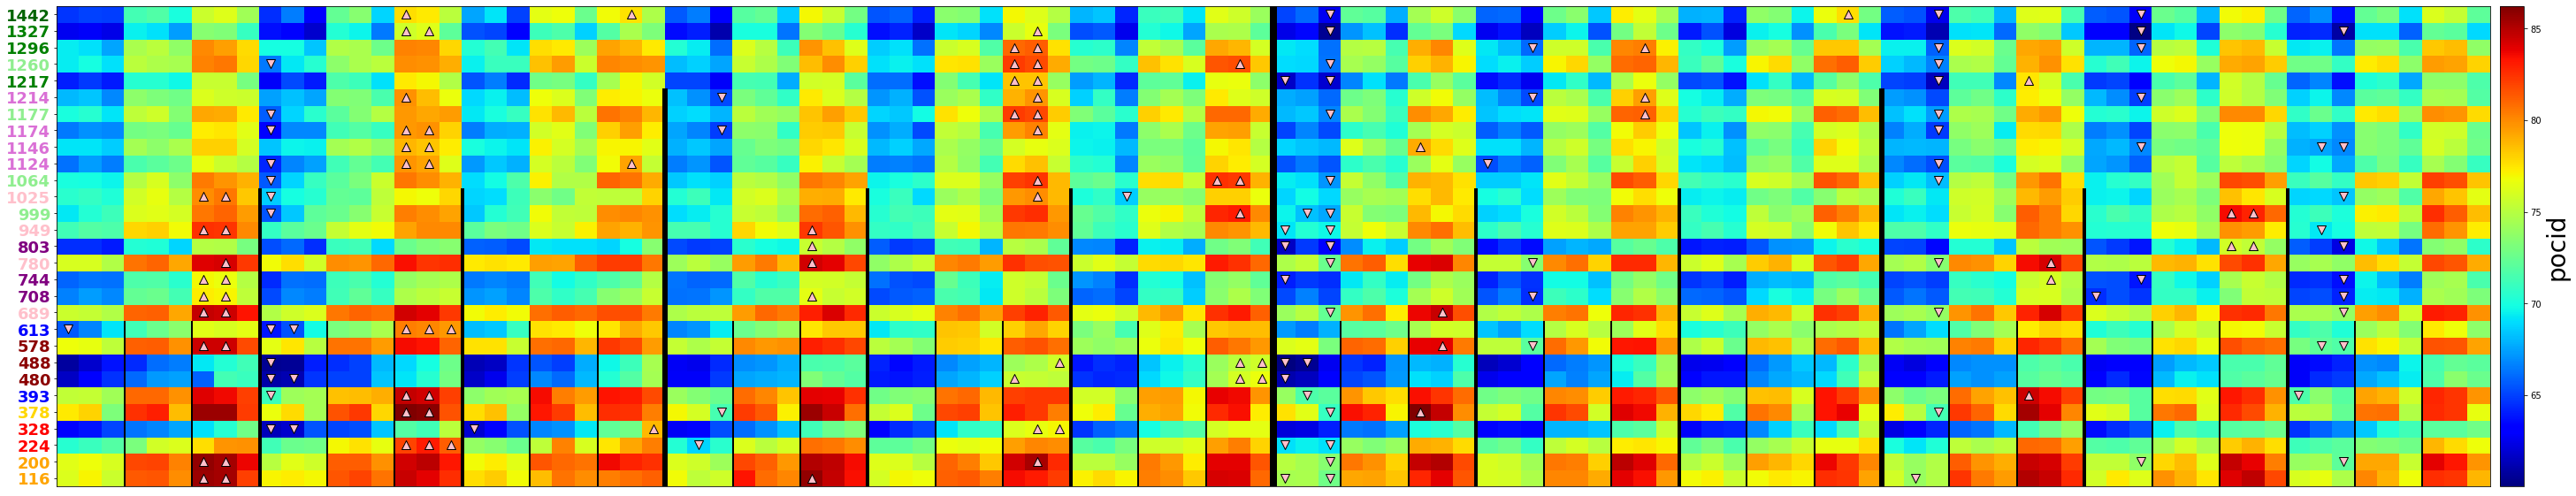

In [9]:
results.plot_allmodels_stats(stats_plot='xgb', # 'linear'/'knn'/'xgb'
                             metrics_to_plot=['kgeprime','pocid'])

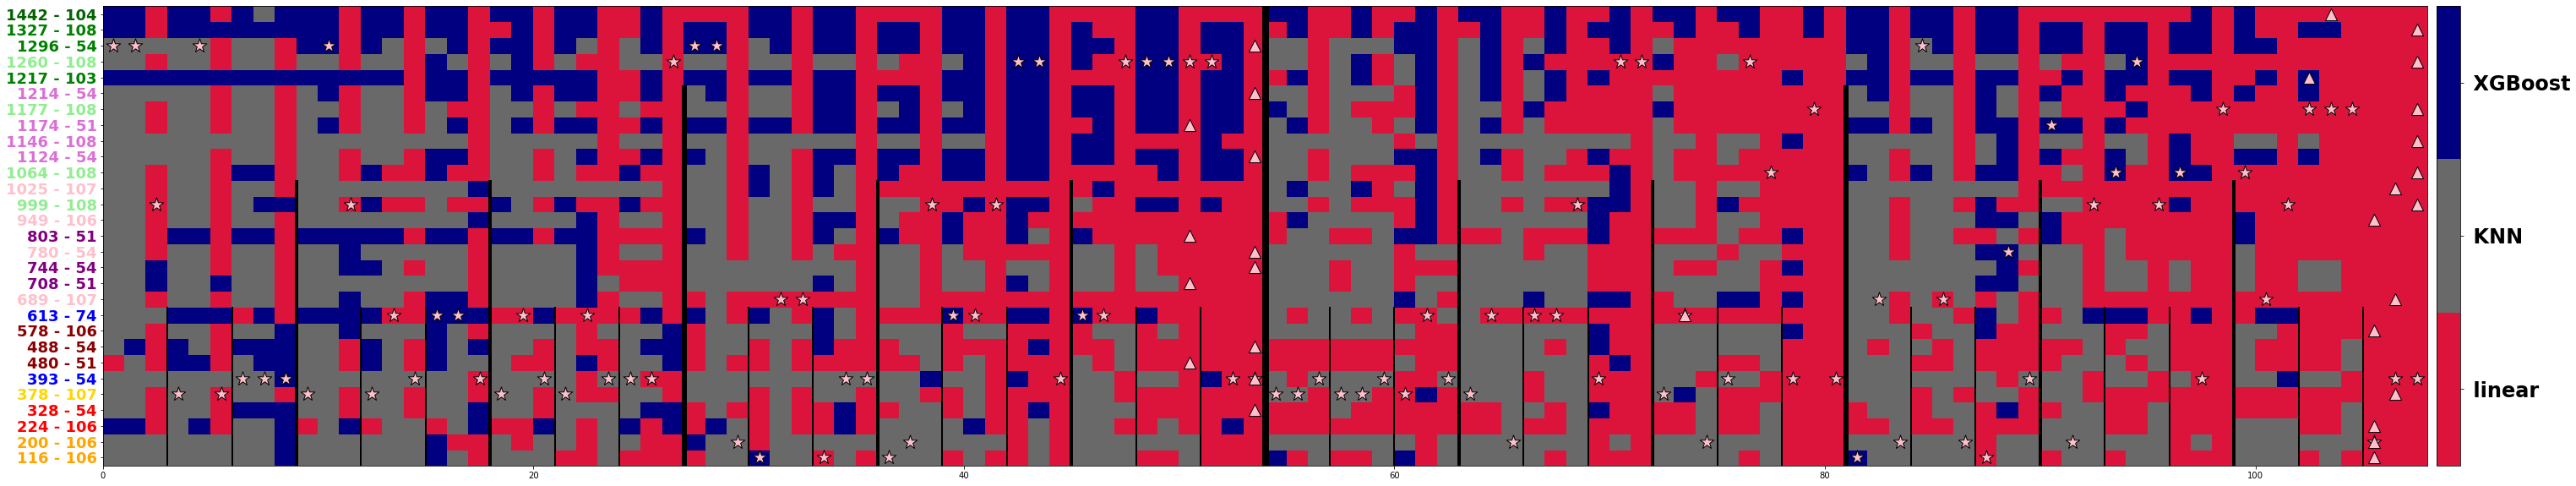

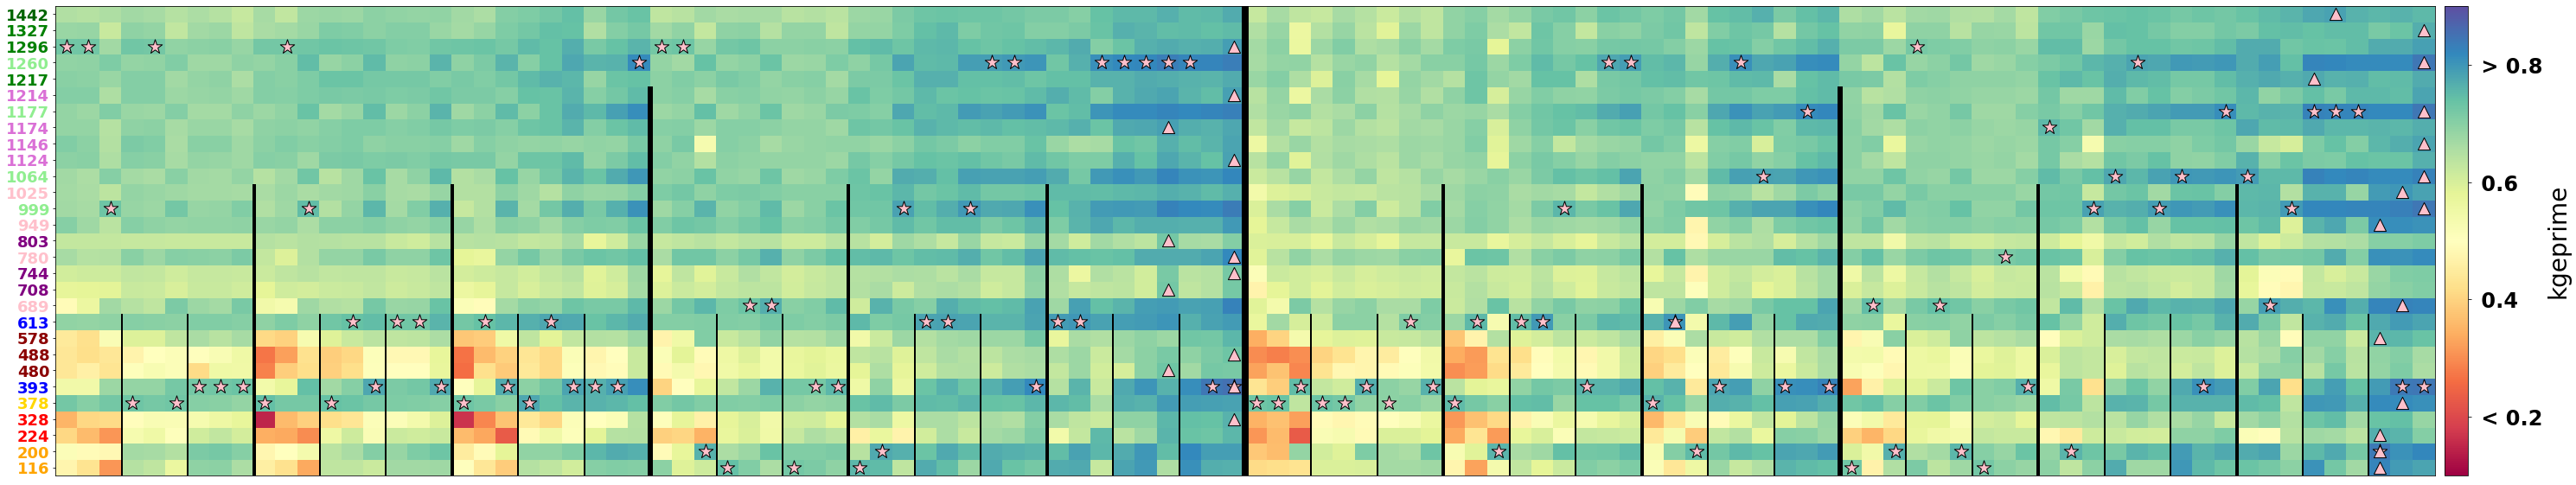

In [10]:
results.plot_best_stat()

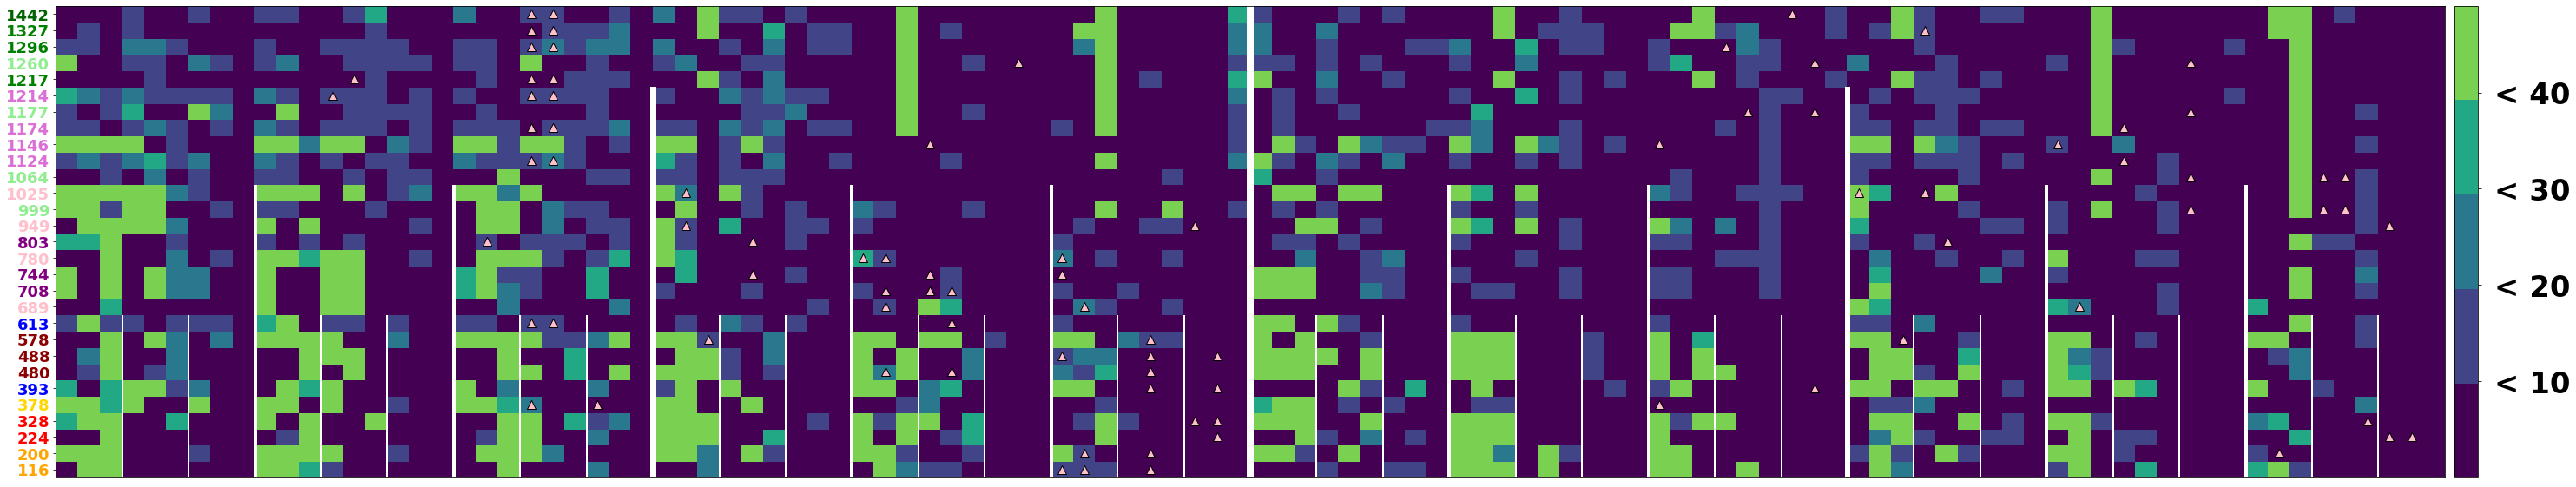

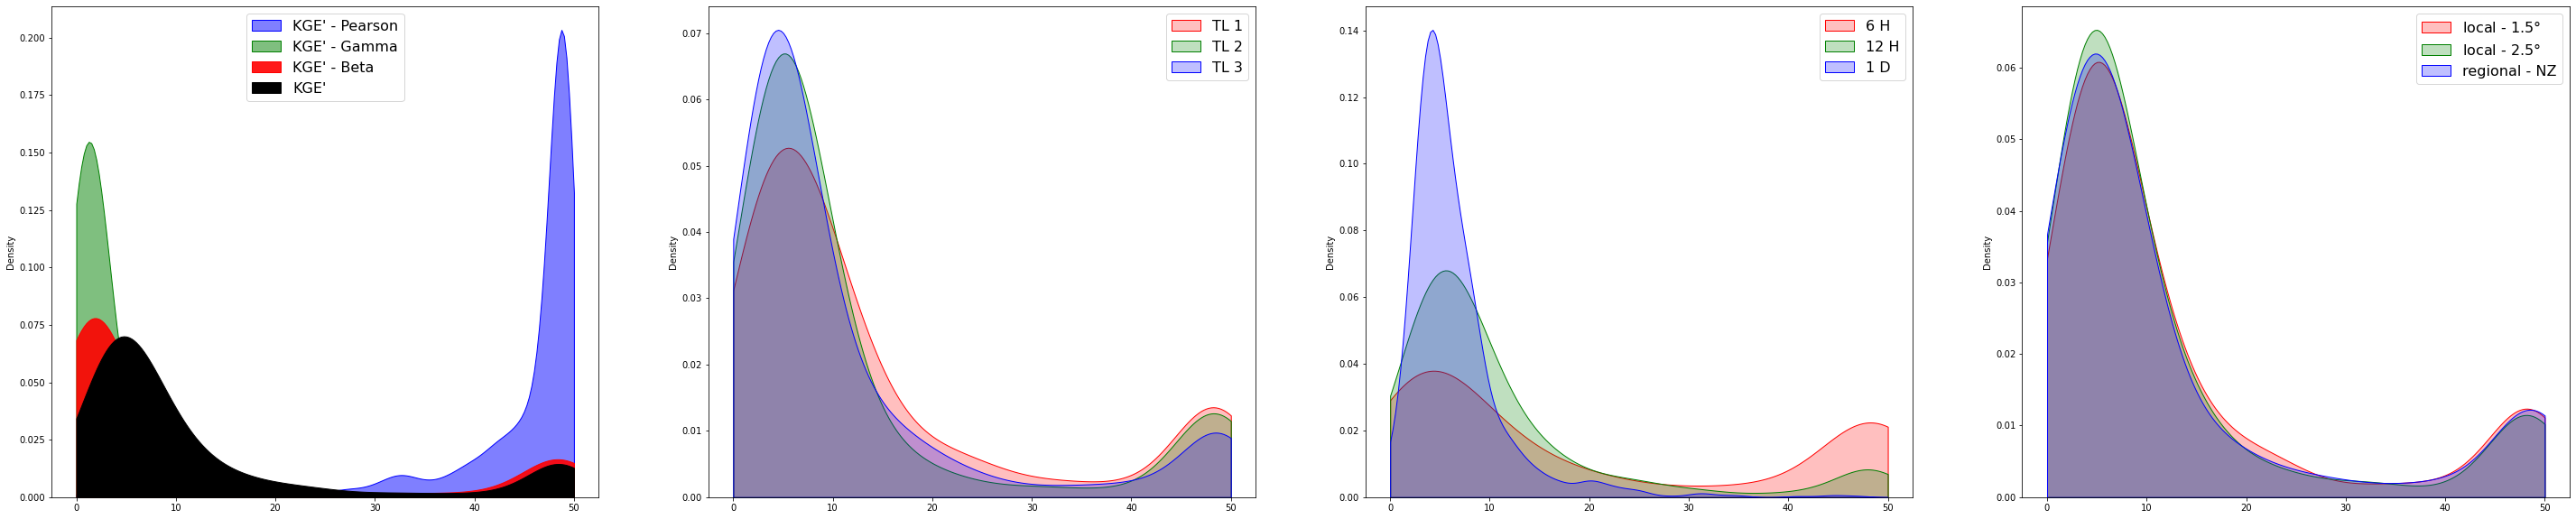

In [11]:
results.plot_knn_stats()

## PCs analysis

In [44]:
linear_stats

<xarray.Dataset>
Dimensions:                (site: 29, grad: 2, winds: 2, tlapse: 3, tresample: 3, region: 3, tsize: 1, perpcs: 6)
Coordinates:
  * site                   (site) int64 116 200 224 328 ... 1260 1296 1327 1442
  * grad                   (grad) int8 0 1
  * winds                  (winds) int8 0 1
  * tlapse                 (tlapse) int64 1 2 3
  * tresample              (tresample) object '6H' '12H' '1D'
  * region                 (region) object 'local_1.5_1.5' ... 'default_regio...
  * tsize                  (tsize) float64 0.7
  * perpcs                 (perpcs) float64 0.9 0.95 0.96 0.97 0.98 0.99
Data variables: (12/61)
    bias                   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    si                     (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse                   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rel_rmse               (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse_9                 (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    rmse_95                (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ...                     ...
    ext_kgeprime_gamma_95  (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_beta_95   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_99        (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_r_99      (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_gamma_99  (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...
    ext_kgeprime_beta_99   (site, grad, winds, tlapse, tresample, region, tsize, perpcs) float64 ...

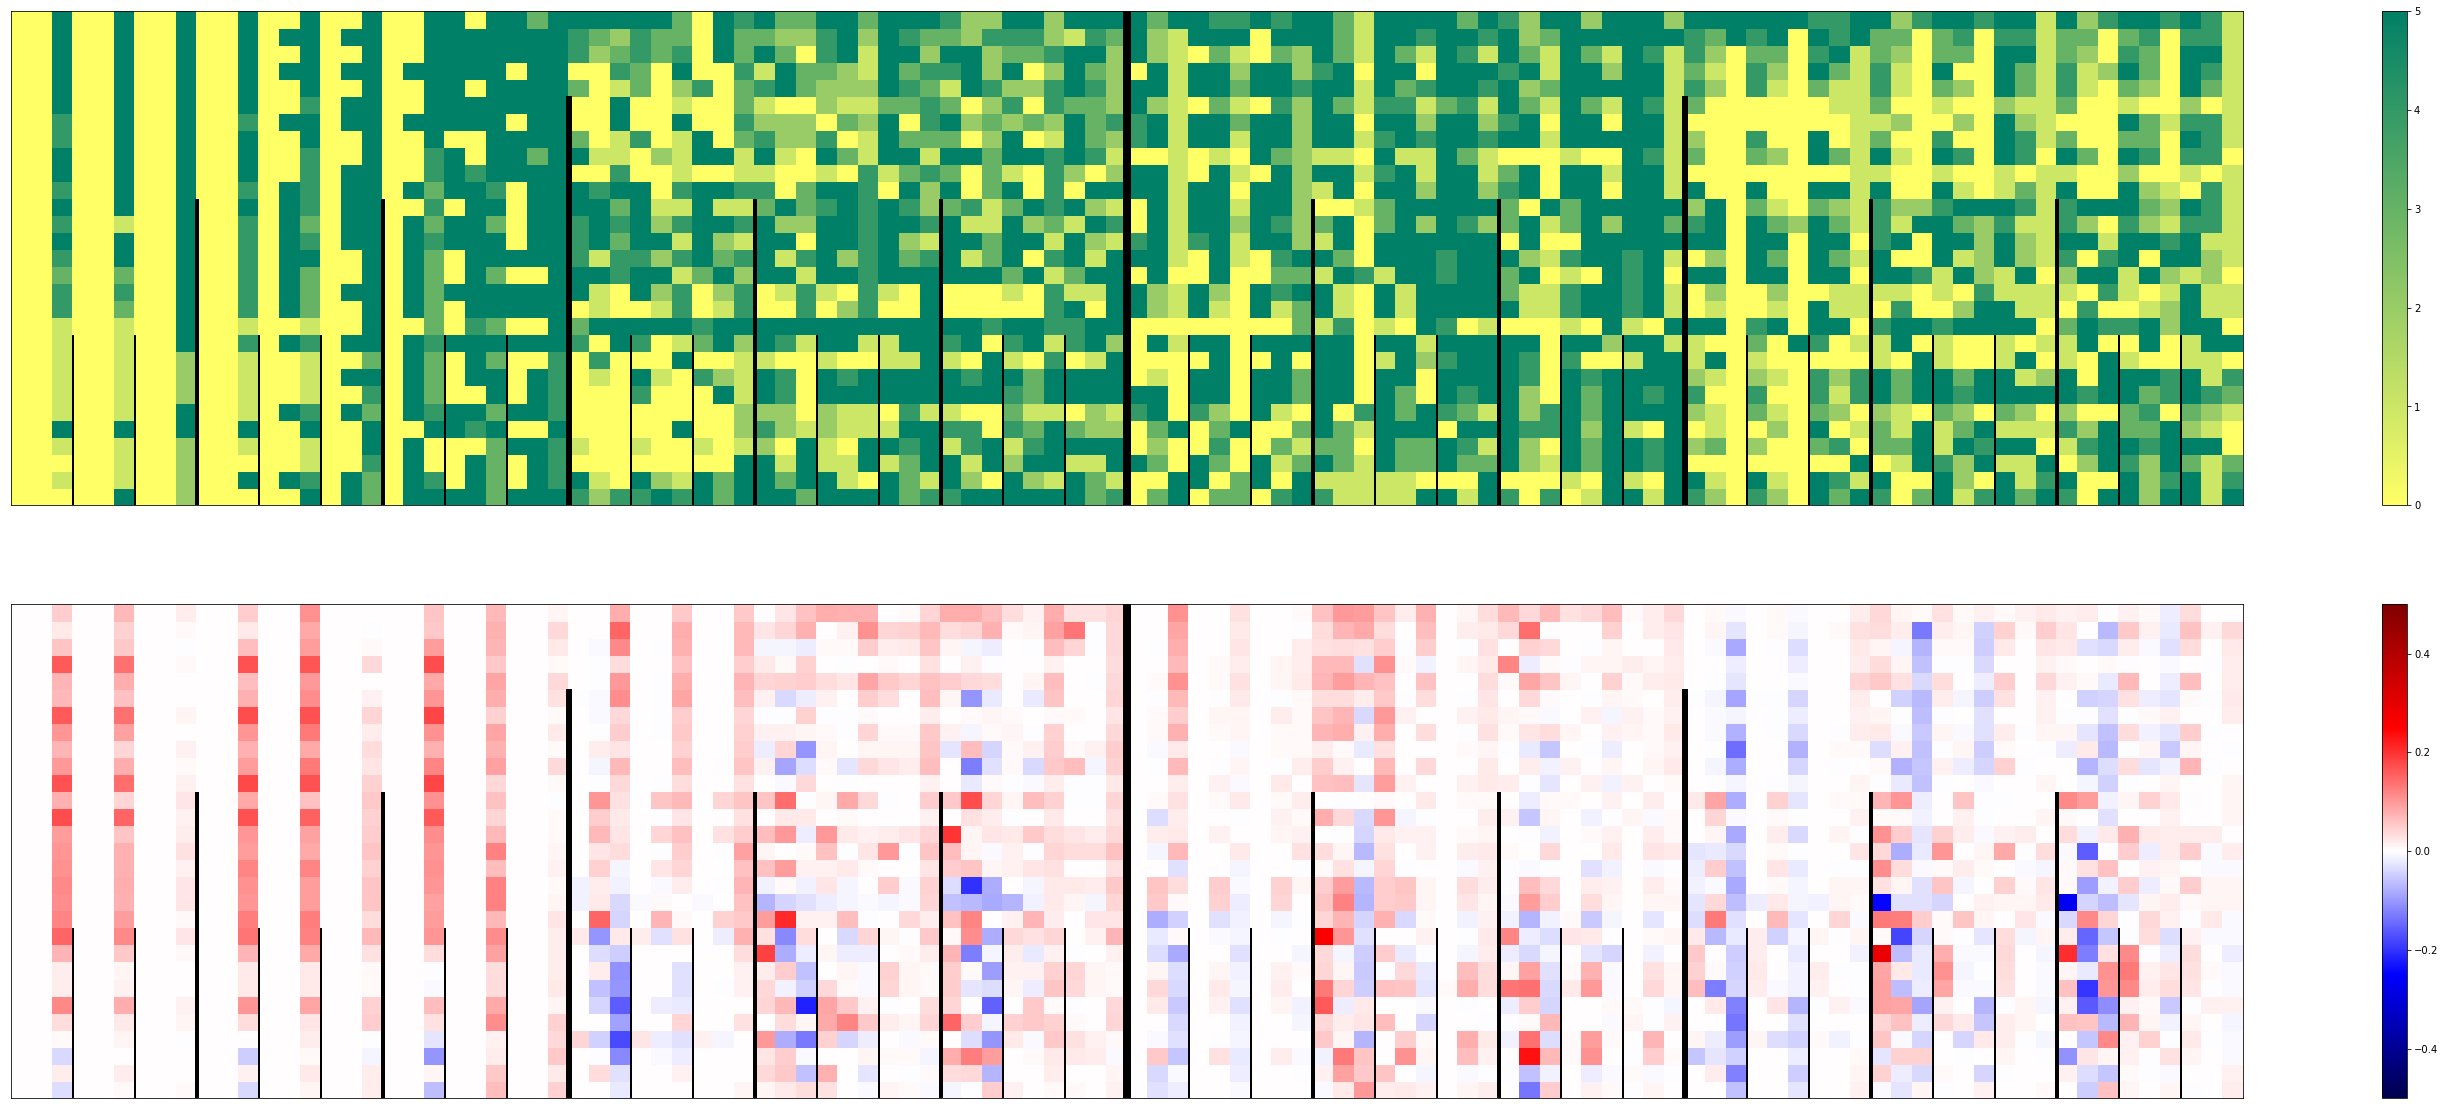

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(figsize=(50,20),nrows=2)
pc1 = axes[0].pcolor(
    linear_stats.kgeprime.argmax(axis=7).values.reshape(29,-1),cmap='summer_r'
)
fig.colorbar(pc1,ax=axes[0])
pc2 = axes[1].pcolor(
    (linear_stats.kgeprime.isel(perpcs=1)-linear_stats.kgeprime.isel(perpcs=0)).values.reshape(29,-1),
    cmap='seismic',vmin=-0.5,vmax=0.5
)
fig.colorbar(pc2,ax=axes[1])
for ax in axes:
    for xline,vs,lws in zip( # add lines to better visualization
        [np.arange(0,108,54)[1:],np.arange(0,108,27)[1:],np.arange(0,108,9)[1:],np.arange(0,108,3)[1:]],
        [29,24,18,10],[8,6,4,2]
    ):
        ax.vlines(xline,lw=lws,colors='k',ymax=vs,ymin=0)
        ax.set_xticks([]), ax.set_yticks([])